In [7]:
import glob
import os

from astropy.io import ascii, fits
from photutils import detect_sources
from astropy.table import Table
%load_ext autoreload
%autoreload 2
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import numpy as np
from ginga.util import zscale
from photutils import deblend_sources, source_properties, CircularAperture, CircularAnnulus, aperture_photometry
from make_pamcorr import *
from wfc3_photometry import photometry_tools
from astropy.wcs import WCS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def mask_sources_border_chipgap_drizzle_ACS(source_catalog, npix = 50):
    """ Excludes sources in a catalog within npix of the border of a
    drizzled ACS image, accounting for the fact that the image is not a perfect
    rectangle anymore after projection. """

    print('*** Filtering source catalog for sources within {} pixels of top, bottom, and chipgap ***'.format(npix))

    #define equations of lines that trace top and bottom edge
    top_line = lambda x : 0.05 * x + 4115
    bottom_line = lambda x : 0.03 * x

    #exclude sources within npix of top
    filtered_cat = source_catalog[np.abs((top_line(source_catalog['xcentroid'].value))
                    -source_catalog['ycentroid'].value)>npix]
    #exclude sources within npix of bottom
    filtered_cat = filtered_cat[np.abs((bottom_line(filtered_cat['xcentroid'].value))
                    -filtered_cat['ycentroid'].value)>npix]

    #define line that traces chip gap
    chip_line = lambda x: 0.04 * x + 2078
    filtered_cat = filtered_cat[np.abs((chip_line(filtered_cat['xcentroid'].value))
                    -filtered_cat['ycentroid'].value)>npix]

    return(filtered_cat)

In [18]:
data_dir = '/Users/cshanahan/Desktop/clean_desktop/WD_acs/data/cmd_p9/'
flcs = glob.glob(data_dir + '*/*flc.fits')
output_dir_my_phot = '/Users/cshanahan/Desktop/clean_desktop/WD_acs/output/'
my_drcs = glob.glob(data_dir+'*/*drc.fits')
mdriztab_file = '/grp/hst/cdbs/jref/16r12191j_mdz.fits'
mdriztab = fits.open(mdriztab_file)
output_photcats_me = glob.glob(output_dir_my_phot+'*photcat*')

[]

In [19]:
# dq_flc = fits.open(flcs[0])[3].data
# np.sum(np.bitwise_and(dq_flc,1024)/1024)

In [22]:
#pick random file
test_drc = my_drcs[0]
print(test_drc)
data = fits.open(test_drc)[1].data

# pipeline_drizzle = pipeline_data_dir + fits.getval(flcs[0],'asn_tab').replace('_asn.fits','_drc.fits')
# print(pipeline_drizzle)

/Users/cshanahan/Desktop/clean_desktop/WD_acs/data/cmd_p9/F625W/jcmdp9030_drc.fits


In [39]:
sigma = 1.8 * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data, threshold = 20.*np.nanmean(data.flatten()), npixels=40, filter_kernel=kernel)
segm_cat = source_properties(data, segm).to_table()
# ascii.write(segm_cat,'/Users/cshanahan/Desktop/WD_acs/data/cmd_p9/F625W/segmsources.csv')
xx = segm_cat['xcentroid']
print(xx[0].value)

/Users/cshanahan/miniconda3/envs/astroconda36/lib/python3.6/site-packages/photutils/segmentation/detect.py:128: RuntimeWarning: invalid value encountered in greater
  check_normalization=True) > threshold)


980.2444569458058


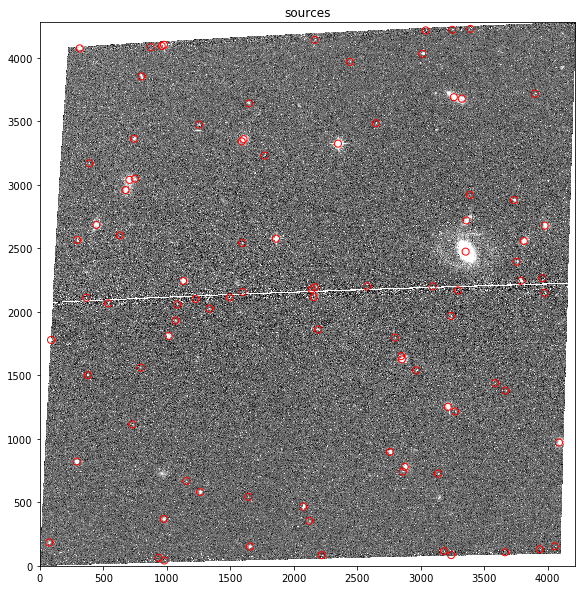

In [7]:
plt.figure(figsize=(10,10))
z1,z2 = zscale.zscale(data)
plt.imshow(data, origin='lower', cmap='Greys_r', vmin = z1, vmax = z2)
plt.scatter(segm_cat['xcentroid'],segm_cat['ycentroid'],facecolor = 'None', edgecolor='r',s = 50)
plt.title('sources')

In [21]:
print(test_drc)
print(pipeline_drizzle)
input_flcs = glob.glob(test_drc.replace(os.path.basename(test_drc), '*flc.fits'))
print(input_flcs)
input_pamcorr_flcs = []
#make_pamcorr
for flc in input_flcs:
    pamcor_flc = make_PAMcorr_image(flc)
    input_pamcorr_flcs.append(pamcor_flc)
print(input_pamcorr_flcs)

/Users/cshanahan/Desktop/clean_desktop/WD_acs/data/cmd_p9/F625W/jcmdp9030_drc.fits


NameError: name 'pipeline_drizzle' is not defined

In [9]:
#source_cat = mask_sources_border_chipgap_drizzle_ACS(source_properties(data, segm).to_table())
source_cat = source_properties(data, segm).to_table()

In [10]:
source_cat_chip2 = source_cat[source_cat['ycentroid'].value < 2000]
source_cat_chip2 = source_cat_chip2[source_cat_chip2['ycentroid'].value > 200]
source_cat_chip2 = source_cat_chip2[source_cat_chip2['xcentroid'].value > 100]
source_cat_chip2 = source_cat_chip2[source_cat_chip2['xcentroid'].value < 4000]

apertures = CircularAperture((source_cat_chip2['xcentroid'], source_cat_chip2['ycentroid']), r=10)
sky_apertures = CircularAnnulus((source_cat_chip2['xcentroid'], source_cat_chip2['ycentroid']), 20, 25)

photcat_my_drizzle_chip2 = aperture_photometry(fits.open(test_drc)[1].data, apertures)
medsky_my_drizzle_chip2 = photometry_tools.aperture_stats_tbl(fits.open(test_drc)[1].data, sky_apertures)['aperture_median']
photcat_my_drizzle_chip2['med_sky_annulus'] = medsky_my_drizzle_chip2

photcat_pipeline_drizzle_chip2 = aperture_photometry(fits.open(pipeline_drizzle)[1].data, apertures)
medsky_pipeline_drizzle_chip2 = photometry_tools.aperture_stats_tbl(fits.open(pipeline_drizzle)[1].data, sky_apertures)['aperture_median']
photcat_pipeline_drizzle_chip2['med_sky_annulus'] = medsky_pipeline_drizzle_chip2

#add sky positions
w_drc = WCS(fits.open(test_drc)[1].header)
ra_targs, dec_targs = w_drc.wcs_pix2world(source_cat_chip2['xcentroid'],source_cat_chip2['ycentroid'], 0)
source_cat_chip2['ra'] = ra_targs
source_cat_chip2['dec'] = dec_targs

photcat_pipeline_drizzle_chip2['aperture_sum'] = photcat_pipeline_drizzle_chip2['aperture_sum']-(np.pi*100*medsky_pipeline_drizzle_chip2)
photcat_my_drizzle_chip2['aperture_sum'] = photcat_my_drizzle_chip2['aperture_sum'] - (np.pi*100*medsky_my_drizzle_chip2)
photcat_pipeline_drizzle_chip2.remove_column('med_sky_annulus')
photcat_my_drizzle_chip2.remove_column('med_sky_annulus')

/Users/cshanahan/Desktop/WD_acs/wfc3_photometry/photometry_tools/background_median.py:93: RuntimeWarning: invalid value encountered in true_divide
  values = cutout * mask.data / mask.data


In [11]:
#now do photometry on flcs
photcats_flcs = []
for flc in input_pamcorr_flcs:
    
    wcs = WCS(fits.open(flc)[1].header, fits.open(flc))
    xcent, ycent = wcs.all_world2pix(source_cat_chip2['ra'], source_cat_chip2['dec'], 0)

    apertures = CircularAperture((xcent, ycent), r=10)
    sky_apertures = CircularAnnulus((xcent,ycent), 20, 25)
    
    data_chip_2 = fits.open(flc)[1].data
    exptime = fits.getval(flc, 'exptime', ext = 0)
    data_chip_2 = data_chip_2/exptime
    photcat_flc = aperture_photometry(data_chip_2, apertures)
    medsky = photometry_tools.aperture_stats_tbl(data_chip_2, sky_apertures)['aperture_median']
    photcat_flc['aperture_sum'] = photcat_flc['aperture_sum']- (np.pi*100*medsky)
    photcats_flcs.append(photcat_flc)


/Users/cshanahan/Desktop/WD_acs/wfc3_photometry/photometry_tools/background_median.py:93: RuntimeWarning: invalid value encountered in true_divide
  values = cutout * mask.data / mask.data


In [12]:
def add_fwhm_to_photcat(data, photcat):
    """Uses wfc3photometry tool to fit a radial profile to every object in
    in the photometry table and adds the FWHM as a column."""

    print('*** Measuring FWHM of sources ***')
    fwhms = []
    for i, val in enumerate(photcat):
        x, y = photcat['xcenter'][i].value, photcat['ycenter'][i].value
        rad_prof = photometry_tools.rad_prof.RadialProfile(x, y, data)
        plt.show()
        fwhms.append(rad_prof.fwhm)

    photcat['fwhm'] = fwhms
    return photcat

In [13]:
#add fwhm to tables 
photcats_flcs[0] = add_fwhm_to_photcat(fits.open(flcs[0])[1].data, photcats_flcs[0])
photcats_flcs[1] = add_fwhm_to_photcat(fits.open(flcs[1])[1].data, photcats_flcs[1])
photcat_my_drizzle_chip2 = add_fwhm_to_photcat(data, photcat_my_drizzle_chip2)
photcat_pipeline_drizzle_chip2 = add_fwhm_to_photcat(data, photcat_pipeline_drizzle_chip2)

*** Measuring FWHM of sources ***
*** Measuring FWHM of sources ***
*** Measuring FWHM of sources ***
*** Measuring FWHM of sources ***


(0, 1.5)

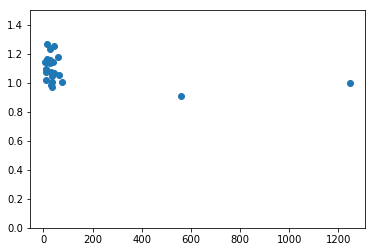

In [14]:
ap_sum_tab = Table(names = ['flc0', 'flc1', 'mine', 'pipeline', 'fwhm', 'xdriz', 'ydriz'], 
                   data = [photcats_flcs[0]['aperture_sum'],photcats_flcs[1]['aperture_sum'],
                          photcat_my_drizzle_chip2['aperture_sum'], photcat_pipeline_drizzle_chip2['aperture_sum'],
                          photcat_my_drizzle_chip2['fwhm'], photcat_my_drizzle_chip2['xcenter'],
                          photcat_my_drizzle_chip2['ycenter']])

plt.scatter(ap_sum_tab['pipeline'],np.mean([ap_sum_tab['flc0'],ap_sum_tab['flc1']], axis = 0)/ap_sum_tab['mine'])
plt.ylim(0,1.5)

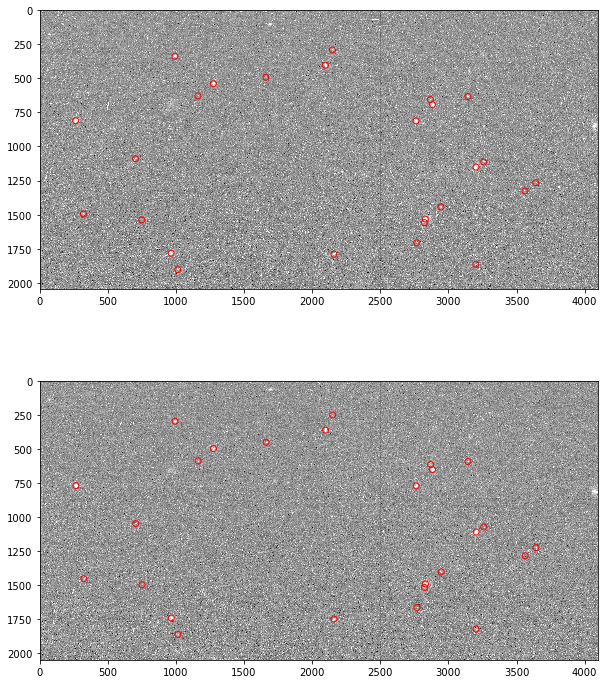

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
z1,z2 = zscale.zscale(fits.open(flcs[0])[1].data)
ax1.imshow(fits.open(flcs[0])[1].data, vmin = z1, vmax = z2, cmap = 'Greys_r')
ax1.scatter(photcats_flcs[0]['xcenter'], photcats_flcs[0]['ycenter'], edgecolor = 'r', facecolor = 'None')
z1,z2 = zscale.zscale(fits.open(flcs[1])[1].data)
ax2.imshow(fits.open(flcs[1])[1].data, vmin = z1, vmax = z2, cmap = 'Greys_r')
ax2.scatter(photcats_flcs[1]['xcenter'], photcats_flcs[1]['ycenter'], edgecolor = 'r', facecolor = 'None')

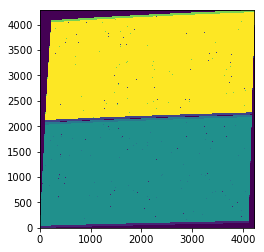

In [16]:
ctx = fits.open(test_drc)[3].data
ctx[np.isnan(ctx)] = 0
plt.imshow(ctx, origin = 'lower')
